In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
from torchvision.transforms import v2


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
children = os.listdir('/content/drive/MyDrive/ECE 561 MV Project/Dataset/ds000228/derivatives/processed/Ages7-12')
infants = os.listdir('/content/drive/MyDrive/ECE 561 MV Project/Dataset/ds000228/derivatives/processed/Ages3-5')
adults = os.listdir('/content/drive/MyDrive/ECE 561 MV Project/Dataset/ds000228/derivatives/processed/Adults')

In [ ]:
os.listdir('/content/drive/MyDrive/ECE 561 MV Project/Dataset/ds000228/derivatives/processed/')

['Ages7-12', 'Adults', 'Ages3-5']

In [ ]:
#children.remove('.DS_Store')
#infants.remove('.DS_Store')
#adults.remove('.DS_Store')

In [ ]:
len(children)

114

In [ ]:
children_images = []
infants_images = []
adults_images = []

path = '/content/drive/MyDrive/ECE 561 MV Project/Dataset/ds000228/derivatives/processed/'

for each in children :
    image = cv2.imread(path + 'Ages7-12/' + each)

    children_images.append(image)

for each in infants :
    image = cv2.imread(path + 'Ages3-5/' + each)
    #if image != None :
    infants_images.append(image)

for each in adults :
    image = cv2.imread(path + 'Adults/' + each)
    #if image != None :
    adults_images.append(image)

children_df = pd.DataFrame({'image' : children_images, 'label' : [1]*len(children_images)})
infants_df = pd.DataFrame({'image' : infants_images, 'label' : [0]*len(infants_images)})
adults_df = pd.DataFrame({'image' : adults_images, 'label' : [2]*len(adults_images)})

dataset_df = pd.concat([children_df, infants_df, adults_df], axis = 0)

In [ ]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MRIImageDataset(Dataset):
    def __init__(self, dataset_df, transform=None, target_transform=None):
        self.img_labels = dataset_df['label']
        self.img_dir = dataset_df['image']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        raw_image = self.img_dir.iloc[idx]
        #raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
        raw_image = cv2.resize(raw_image, (224, 224))
        # Add channel dimension for single channel (grayscale) image
        image = raw_image/255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float() # Add channel dimension

        label = self.img_labels.iloc[idx]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
dataset = MRIImageDataset(dataset_df)

In [ ]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [240, 30, 40])
dataset_sizes = {'train' : 240, 'test':40, 'val':30}

In [ ]:
batch_size = 8
num_workers = 0
dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=torch.cuda.is_available()
        )
    }

# Test the shape
for images, labels in dataloaders['train']:
    print("Image shape:", images.shape)
    print("Labels shape:", labels.shape)
    break

Image shape: torch.Size([8, 3, 224, 224])
Labels shape: torch.Size([8])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_transformer.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase == 'train' :
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)

                if phase == 'val' :
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, train_loss, val_loss, train_acc, val_acc

In [ ]:
model_ft = models.swin_t(weights='IMAGENET1K_V1')
num_classes = 3
model_ft.head = torch.nn.Linear(model_ft.head.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 1.0434 Acc: 0.4292
val Loss: 1.0022 Acc: 0.3333

Epoch 2/25
----------
train Loss: 0.9263 Acc: 0.5000
val Loss: 0.7846 Acc: 0.6667

Epoch 3/25
----------
train Loss: 0.7266 Acc: 0.7292
val Loss: 0.5829 Acc: 0.7000

Epoch 4/25
----------
train Loss: 0.5481 Acc: 0.7875
val Loss: 0.3898 Acc: 0.8333

Epoch 5/25
----------
train Loss: 0.4789 Acc: 0.7583
val Loss: 0.3565 Acc: 0.8000

Epoch 6/25
----------
train Loss: 0.3561 Acc: 0.8583
val Loss: 0.3076 Acc: 0.9000

Epoch 7/25
----------
train Loss: 0.3122 Acc: 0.9000
val Loss: 0.2943 Acc: 0.9000

Epoch 8/25
----------
train Loss: 0.3063 Acc: 0.9042
val Loss: 0.2703 Acc: 0.9333

Epoch 9/25
----------
train Loss: 0.3090 Acc: 0.9083
val Loss: 0.2773 Acc: 0.9000

Epoch 10/25
----------
train Loss: 0.2787 Acc: 0.9250
val Loss: 0.2771 Acc: 0.9000

Epoch 11/25
----------
train Loss: 0.3063 Acc: 0.8958
val Loss: 0.2758 Acc: 0.9000

Epoch 12/25
----------
train Loss: 0.2915 Acc: 0.9083
val Loss: 0.2789 Acc: 0.9000

E

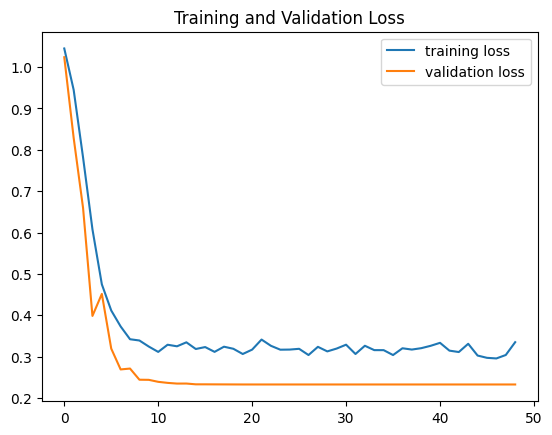

In [ ]:
plt.plot(train_loss[0:49], label = 'training loss')
plt.legend()
plt.plot(val_loss[0:49], label = 'validation loss')
plt.legend()

plt.title('Training and Validation Loss')
plt.show()

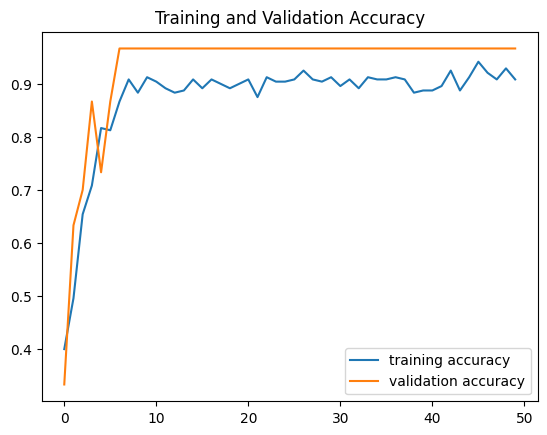

In [ ]:
train_cpu = [tensor.cpu() for tensor in train_acc]
train_acc_list = [tensor.numpy() for tensor in train_cpu]

val_cpu = [tensor.cpu() for tensor in val_acc]
val_acc_list = [tensor.numpy() for tensor in val_cpu]

plt.plot(train_acc_list, label = 'training accuracy')
plt.legend()
plt.plot(val_acc_list, label = 'validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

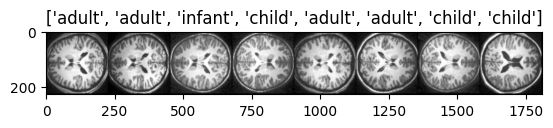

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = {
    0 : 'infant',
    1 : 'child',
    2 : 'adult'
}

imshow(out, title=[class_names[x.item()] for x in classes])

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'  label: {class_names[labels[j].item()]} predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

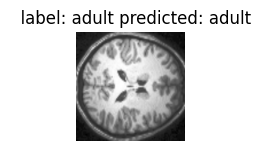

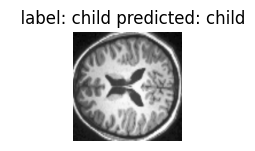

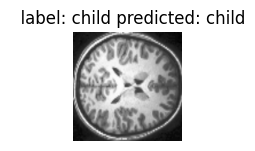

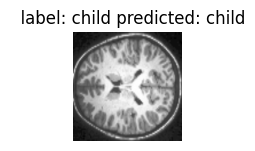

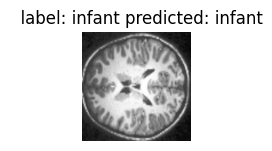

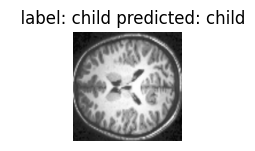

In [ ]:
visualize_model(model_ft)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:


device = torch.device("cpu")
running_corrects = 0
for image, labels in iter(dataloaders['test']) :

    model_ft = model_ft.to(device)
    image = image.to(device)
    model_ft.eval()
    outputs = model_ft(image)
    _, preds = torch.max(outputs,1)
    running_corrects += torch.sum(preds == labels.data)

In [ ]:
print("The test accuracy obtained is: " + str(running_corrects.numpy()/40))

The test accuracy obtained is: 0.925


In [ ]:
device = torch.device("cpu")
model_ft = model_ft.to(device)

# Placeholders for true labels and predictions
all_preds = []
all_labels = []

# Switch to evaluation mode
model_ft.eval()

# Loop over test data
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Flatten lists of tensors to single tensors
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds, normalize='true')
report = classification_report(all_labels, all_preds, target_names=class_names.values(), digits=4)

# Print results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)

Accuracy: 0.925

Confusion Matrix:
 [[0.91666667 0.08333333 0.        ]
 [0.11111111 0.88888889 0.        ]
 [0.         0.         1.        ]]

Classification Report:
               precision    recall  f1-score   support

      infant     0.8462    0.9167    0.8800        12
       child     0.9412    0.8889    0.9143        18
       adult     1.0000    1.0000    1.0000        10

    accuracy                         0.9250        40
   macro avg     0.9291    0.9352    0.9314        40
weighted avg     0.9274    0.9250    0.9254        40



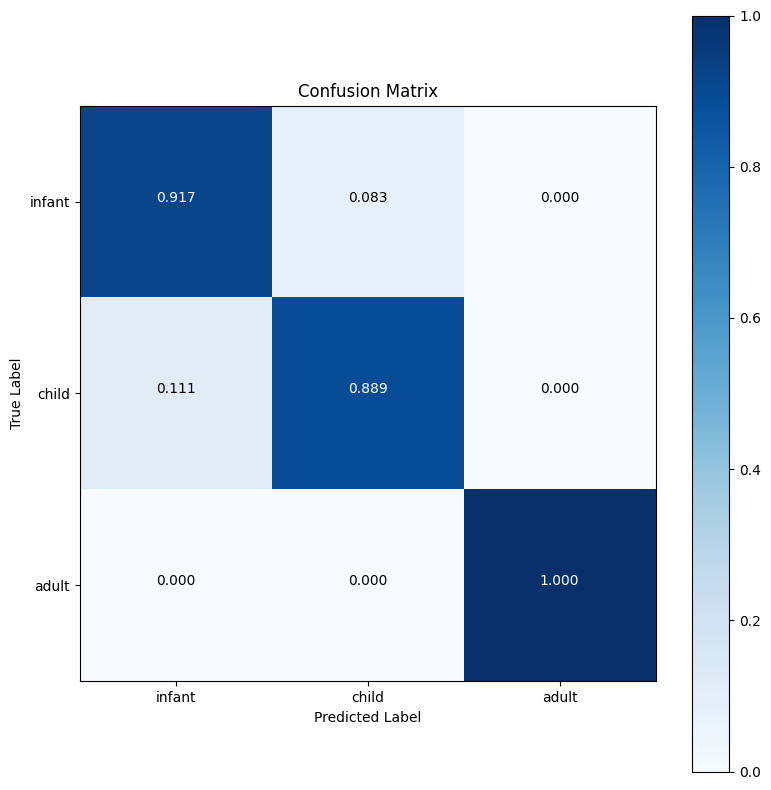

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names.values())
plt.yticks(tick_marks, class_names.values())

# Add text annotations
thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<Axes: >

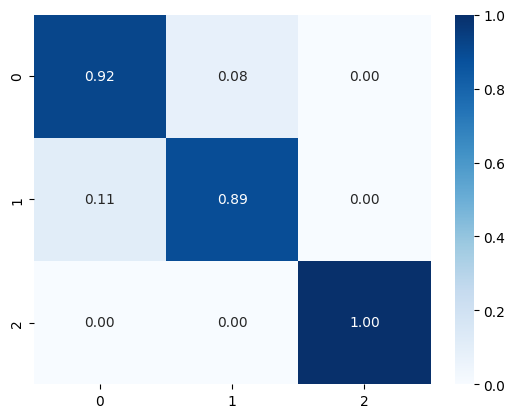

In [ ]:
import seaborn as sns
conf_matrix = confusion_matrix(all_labels, all_preds, normalize='true')
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

40